# Idea & Plan

A few (mostly one) latent feature is always much more important for prediction than the rest (check `feature_importance`) 

- Are the CpGs connected to this latent feature also important? 
- Can we recover the CpGs important for prediction through perturbation? --> **PROOF OF CONCEPT THAT PERTURBATIONS WORK?!**

**Workflow**:

1. Predict with input CpGs: maximum R2?
2. Predict with all latent features: maximum R2 + important latent features? 
3. Predict only with important latent feature --> this is the maximum we can achieve!
4. Recover CpGs connected to this latent feature through perturbations (`low` + `medium` + `high` effect)
5. Predict AGE with those CpGs --> compare to other results!

In [1]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


In [5]:
def RFregression(X_train, y_train, X_test, y_test, saveModel=False, plot=True, color="orange", title=None):
    ## Remove samples with NA in target
    # Train
    mask_train = ~np.isnan(y_train)
    X_train = X_train[mask_train]
    y_train = y_train[mask_train]
    # Test
    mask_test = ~np.isnan(y_test)
    X_test = X_test[mask_test]
    y_test = y_test[mask_test]

    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # Train RFregression model
    regr = RandomForestRegressor(random_state=None)
    regr.fit(X_train, y_train)
    featureImportances = regr.feature_importances_

    # Score on Test set
    y_pred = regr.predict(X_test)
    r2 = regr.score(X_test, y_test)

    if saveModel:
        # save model
        outPath = f"logs/{name}/regression/"
        os.makedirs(outPath, exist_ok=True)
        pickle.dump(regr, open(f"{outPath}/RFregressor.sav", 'wb'))

    if plot:
        fig, (ax, ax2) = plt.subplots(1, 2,figsize=(15,5))
        ax.scatter(y_test, y_pred, color=color)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red", linestyle="dashed", alpha=0.5)
        ax.text(55, 10, f"R² = {round(r2.mean(),2)}")
        ax.set_xlim(0,100)
        ax.set_ylim(0,100)
        if title: 
            ax.set_title(f"{title}")
        else: 
            ax.set_title(f"{X_train.shape[1]} features")
        ax.set_xlabel("True Age")
        ax.set_ylabel("Predicted Age")

        ax2.bar(x=range(len(featureImportances)), height=featureImportances, color=color)
        ax2.set_title("Feature importance")
        ax2.set_xlabel("# Feature")

    return featureImportances, r2

# Load Data

In [2]:
PATH_data = "data"
PATH_results = "logs"

batch_size = 64
with open(os.path.join(PATH_data, "chr22_overlap_train_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f) #
train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/chr22_overlap_train_methyl_array.pkl", colName="Age").returnTensor_()

with open(os.path.join(PATH_data, "chr22_overlap_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Read in AE model (latent features = 25)

In [3]:
name = f"optLatSize/latSize_25" 
global name
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

# From input CpGs 

## All input CpGs (4671 CpGs)

In [ ]:
fi_all, _ = RFregression(X_train=train_tensor[0].detach().numpy(), 
                         y_train=train_tensor[1].detach().numpy(),
                         X_test=test_dataset["beta"].values,
                         y_test=test_dataset["pheno"]["Age"].values,
                         plot=True,
                         color="red")

## Top xx input Cpgs

- tried Recursive Feature Addition - too slow

In [ ]:
### Test: with xx best CpGs (from input)
i_best = 10
cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
y_train_latFeature = train_dataset["pheno"]["Age"].values
X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
_, r2 = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="darkred")

print(cpgs_best)

In [ ]:
### check which number of top features is best

r2_tmp = []

tmp = list(range(5,501, 5)) #0
#tmp[0] += 1

for i_best in tmp: 
    ### Test: with xx best CpGs (from input)
    cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
    y_train_latFeature = train_dataset["pheno"]["Age"].values
    X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    _, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False,
                                    color="darkred")

    r2_tmp.append(r2)


fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=tmp, y=r2_tmp, color="darkred", marker="o")
ax.set_xlabel("Number of features")
ax.set_ylabel("R2")
ax.set_title("Optimal number of CpG features")

In [ ]:
np.argmax(r2_tmp)
tmp[np.argmax(r2_tmp)]

In [ ]:
### Test: with xx best CpGs (from input)
i_best = tmp[np.argmax(r2_tmp)]
cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
y_train_latFeature = train_dataset["pheno"]["Age"].values
X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
_, r2 = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="brown")

print(cpgs_best)

## Everything except top xx CpGs (e.g. top 100)

In [ ]:
i_best = 100
### everything BUT best `i_best` features
cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[i_best:].index


## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
y_train_latFeature = train_dataset["pheno"]["Age"].values
X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
_, r2 = RFregression(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="tomato")

print(cpgs_best.shape)

# From all latent space features

In [ ]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)  

fi, r2 = RFregression(X_train=latSpace_train, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="orange")

df_fi = pd.DataFrame(fi, index=range(latSpace_train.size(1)), columns=["fi"])
#df_fi

## Pre-experiment: permutation == deletion == perturbation?

In [ ]:
### Pre-experiment: permutation == deletion == perturbation?

latFeature_i = [14,15,16]
print(f"Permuted feature: {latFeature_i}")

### PERTURBATION
with torch.no_grad():
    latSpace_train_pert = model.generate_embedding(train_tensor[0])
    latSpace_train_pert[:,latFeature_i] = latSpace_train_pert[:,latFeature_i] + 10 #3*latSpace_train_pert[:,latFeature_i].std()
    #
    latSpace_test_pert = model.generate_embedding(test_tensor)  
    latSpace_test_pert[:,latFeature_i] = latSpace_test_pert[:,latFeature_i] + 10 #3*latSpace_test_pert[:,latFeature_i].std()

print(latSpace_train_pert.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_pert, 
                          y_train=train_tensor[1].detach().numpy(),
                          X_test=latSpace_test_pert,
                          y_test=test_dataset["pheno"]["Age"].values,
                          plot=True,
                          color="moccasin")


### PERMUTATION
with torch.no_grad():
    latSpace_train_perm = model.generate_embedding(train_tensor[0])
    latSpace_train_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_train_perm[:,latFeature_i]))
    #
    latSpace_test_perm = model.generate_embedding(test_tensor)  
    latSpace_test_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_test_perm[:,latFeature_i]))

print(latSpace_train_perm.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_perm, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_perm,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="gold")

### DELETION
with torch.no_grad():
    latSpace_train_del = model.generate_embedding(train_tensor[0])
    latSpace_train_del = np.delete(latSpace_train_del, latFeature_i, axis=1)
    #
    latSpace_test_del = model.generate_embedding(test_tensor)  
    latSpace_test_del = np.delete(latSpace_test_del, latFeature_i, axis=1)

print(latSpace_train_del.shape)
fi_perm, _ = RFregression(X_train=latSpace_train_del, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_del,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="goldenrod")


## RFE latent features 
Trying to solve mystery that all features are important?!

In [ ]:
latFeature_i = [np.argmax(fi)]

dic_rfe = dict()
for i in range(25):
    print(f"Permuted feature: {latFeature_i}")
    ### PERMUTATION
    with torch.no_grad():
        latSpace_train_perm = model.generate_embedding(train_tensor[0])
        latSpace_train_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_train_perm[:,latFeature_i]))
        #
        latSpace_test_perm = model.generate_embedding(test_tensor)  
        latSpace_test_perm[:,latFeature_i] = torch.tensor(np.random.permutation(latSpace_test_perm[:,latFeature_i]))

    ## plot every 5 features
    if len(latFeature_i) % 5 == 0:
        print(f"Number of permuted features: {len(latFeature_i)} - {latFeature_i}")
        fi_perm, r2_perm = RFregression(X_train=latSpace_train_perm, 
                            y_train=train_tensor[1].detach().numpy(),
                            X_test=latSpace_test_perm,
                            y_test=test_dataset["pheno"]["Age"].values,
                            plot=True,
                            color="dodgerblue", 
                            title=f"Number of permuted features: {len(latFeature_i)}")   ## make it even nicer by coloring the perturbed ones?!
        plt.show()
    else:
        fi_perm, r2_perm = RFregression(X_train=latSpace_train_perm, 
                            y_train=train_tensor[1].detach().numpy(),
                            X_test=latSpace_test_perm,
                            y_test=test_dataset["pheno"]["Age"].values,
                            plot=False)

    dic_rfe[str(latFeature_i)] = r2_perm
    latFeature_i.append(np.argmax(fi_perm))
    
    i += 1



In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(y=dic_rfe.values(), 
             x=[len(list(dic_rfe.keys())[i].split(",")) for i in range(len(dic_rfe.keys()))],
             marker="o",
             ax=ax,
             color="dodgerblue",
             label="permuation")
ax.scatter(x=0, y=r2, color="dodgerblue", label="no permutation", marker="x")
ax.legend()
ax.set_xlabel("Number of permutated features")
ax.set_ylabel("R2")
ax.set_title("Prediction accuracy upon latent feature permutation")

In [ ]:
dic_rfe


# Predict with individual (best) latent features

In [ ]:
# Generate latent space

i = 0 #np.argmax(fi)

with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)  

print(f"Latent space feature with highest importance: {i}")
latSpace_train_highest = latSpace_train[:,i].reshape(-1, 1)
latSpace_test_highest = latSpace_test[:,i].reshape(-1, 1)    

_, _ = RFregression(X_train=latSpace_train_highest, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test_highest,
                     y_test=test_dataset["pheno"]["Age"].values,
                     plot=True,
                     color="green")

# CpG connections

## Connection of input CpGs with highest importance

- connected to many latent features? --> **YES**

In [ ]:
PATH_allcpgs = "/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/quantileCutoff_CpGfocus.csv"
connections_allcpgs = pd.read_csv(PATH_allcpgs, header=0, index_col=0)

In [ ]:
connections_allcpgs

In [ ]:
i_best = 50 #4671
best_cpgs = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index
#print(best_cpgs)

### DENSITY
fig, (ax, ax2) = plt.subplots(1,2,figsize=(16,6))
## all CpGs
sns.kdeplot(data=connections_allcpgs.sum(axis=0), label="all CpGs", ax=ax)
## best CpGs
sns.kdeplot(data=connections_allcpgs.loc[:,best_cpgs].sum(axis=0), label="most important CpGs", ax=ax)
## same number of randomly drawn CpGs
sns.kdeplot(data=connections_allcpgs.iloc[:,np.random.randint(len(connections_allcpgs.columns), size=i_best)].sum(axis=0), label="random CpGs", ax=ax)
ax.legend()
ax.set_title("Connectedness of important CpGs \n(per CpG)")

### PER LATENT FEATURE
sns.barplot(y=connections_allcpgs.loc[:,best_cpgs].sum(axis=1), 
            x=connections_allcpgs.index, 
            ax=ax2)
ax2.set_xticklabels(connections_allcpgs.index,rotation=90)
ax2.set_ylabel("Sum of Connectedness of all CpGs")
ax2.set_title("Connectedness of important CpGs \n(per latent feature)")
plt.suptitle(f"Top {i_best} CpGs", fontsize=20, fontweight ="bold", y=1.05)
plt.show()

print("Order of latent feature permutations:")
print(list(dic_rfe.keys())[-1])

## Retrieve CpG connections for all features

- retrieve CpGs (high effect of perturbation?) for each latent feature
- replicate old findings 

## For all features

In [ ]:
### Test: with CpGs from another (unimportant) latent feature

all_r2 = []
all_fi = []
dic = dict()
for latFeature_i in range(25): #25

    print(f"Latent space feature: {latFeature_i}")
    PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_{latFeature_i}"

    cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None) #cpgs_high_medium_low.txt
    print(f"Number of CpGs connected: {cpgs.shape[0]}")

    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs[0]]
    y_train_latFeature = train_dataset["pheno"]["Age"].values

    X_test_latFeature = test_dataset["beta"].loc[:,cpgs[0]]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    fi_tmp, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False)
                                    #color="lightblue")
    print(r2)

    all_fi.append(fi_tmp)
    all_r2.append(r2)
    dic[latFeature_i] = cpgs[0].tolist()

print(all_r2)

In [ ]:
all_r2

In [ ]:
### TROUBLE PLOT

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=list(range(len(all_r2))), y=all_r2, ax=ax)
ax.set_xlabel('Number of latent feature')
ax.set_ylabel('R2')
ax.set_title('Prediction with CpGs (high effect) for each latent feature')
#ax.set_ylim(0.6, 0.8)

### Analyse in more detail why retrieved latent feature CpGs perform so similar

There should be a difference in mapped CpGs -- therefore also a difference in prediction performance...
--> we don't see this!

- we see that important CpGs have high connectivity and are mapped together in features (resulting in a high degree of connectedness for the features)
- if latent feature inspected alone: diluted and unclear picture -- perturbation deliver too broad results?!

In [ ]:
# def runRFR(cpglist, title, c):
#     ## parse only CpGs connected to latent feature 
#     X_train_latFeature = train_dataset["beta"].loc[:,cpglist]
#     y_train_latFeature = train_dataset["pheno"]["Age"].values
#     X_test_latFeature = test_dataset["beta"].loc[:,cpglist]
#     y_test_latFeature = test_dataset["pheno"]["Age"].values

#     ## predict with those CpGs
#     fi, r2 = RFregression(X_train=X_train_latFeature, 
#                                     y_train=y_train_latFeature,
#                                     X_test=X_test_latFeature,
#                                     y_test=y_test_latFeature,
#                                     plot=True,
#                                     color=c,
#                                     title=title)
#     plt.show()

In [ ]:
## load feature importances of all CpGs
df_fi = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)
df_fi['idx'] = range(df_fi.shape[0])

In [ ]:
### CpGs overlapping between features

#[12, 13, 3, 23, 11, 2, 15, 18, 22, 21, 5, 20, 14, 19, 9, 10, 24, 8, 1, 17, 16, 4, 7, 6, 10]

cpgs_0 = dic[10]   ### This feature is very very unimportant for prediction - should have worthless CpGs connected to it 
cpgs_15 = dic[12]   ### This feature is important for prediction - should have important CpGs connected to it 
cpgs_3 = dic[13]     ### Another important feature
cpgs_10 = dic[4]     ### Unimportant feature

## 1. CpGs overlapping between important and unimportant features             ## Overlapping CpGs are not important at all - they can not be the reason for the same performance
print([i for i in cpgs_15 if i in cpgs_0])
print(df_fi.loc[[i for i in cpgs_15 if i in cpgs_0],:])     

## 1B. CpGs overlapping between important features
print([i for i in cpgs_15 if i in cpgs_3])
print(df_fi.loc[[i for i in cpgs_15 if i in cpgs_3],:])   

## 1c. CpGs overlapping between unimportant features
print([i for i in cpgs_0 if i in cpgs_10])
print(df_fi.loc[[i for i in cpgs_0 if i in cpgs_10],:])   


## For a selected latent feature (e.g. 12)

In [ ]:
latFeature_i = 12

print(f"Latent space feature with highest importance: {latFeature_i}")
PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_{latFeature_i}"

cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None) #cpgs_high_medium_low.txt
print(f"Number of CpGs connected: {cpgs.shape[0]}")

## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs[0]]
y_train_latFeature = train_dataset["pheno"]["Age"].values

X_test_latFeature = test_dataset["beta"].loc[:,cpgs[0]]
y_test_latFeature = test_dataset["pheno"]["Age"].values

## predict with those CpGs
fi_i, r2_cpgRetrieved = RFregression(X_train=X_train_latFeature, 
                    y_train=y_train_latFeature,
                    X_test=X_test_latFeature,
                    y_test=y_test_latFeature,
                    plot=True,
                    color="blue",
                    title=f"{len(cpgs[0])} CpGs of latent feature: {latFeature_i}")

## For randomly selected CpGs (with same number of CpGs as latent features)

In [ ]:
all_r2_random = []

for i_iter in range(30):
    ### Test: with xx random CpGs (same as best latent feature)
    i = len(fi_i)
    cpgs = np.random.choice(train_dataset["beta"].columns, i)


    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs]
    y_train_latFeature = train_dataset["pheno"]["Age"].values

    X_test_latFeature = test_dataset["beta"].loc[:,cpgs]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    _, r2 = RFregression(X_train=X_train_latFeature, 
                                    y_train=y_train_latFeature,
                                    X_test=X_test_latFeature,
                                    y_test=y_test_latFeature,
                                    plot=False)
                                    # plot=True,
                                    # color="cyan")
    all_r2_random.append(r2)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

print(np.array(all_r2_random).mean(), np.array(all_r2_random).std())

sns.violinplot(data=all_r2_random, color="cornflowerblue", inner="point") #"cornflowerblue"
ax.hlines(r2_cpgRetrieved, -0.5,0.5, color="red", linestyles='dashed')
ax.set_title(f"R2 of {len(fi_i)} random CpGs")
ax.set_xticklabels("")
plt.show()

print(np.array(all_r2_random).mean(), np.median(all_r2_random),np.array(all_r2_random).std())

In [ ]:
np.mean(all_r2_random)

# Idea: always put accuracy in relation to R2 of random CpGs

because age prediction is so messy...

In [6]:
## 1. derive prediction for each latent feature only

all_r2_latFeature = []

for latFeature_i in range(25): #25
    with torch.no_grad():
        latSpace_train = model.generate_embedding(train_tensor[0])
        latSpace_test = model.generate_embedding(test_tensor)  

    print(f"Latent space feature with highest importance: {latFeature_i}")
    latSpace_train_highest = latSpace_train[:,latFeature_i].reshape(-1, 1)
    latSpace_test_highest = latSpace_test[:,latFeature_i].reshape(-1, 1)    

    _, r2 = RFregression(X_train=latSpace_train_highest, 
                        y_train=train_tensor[1].detach().numpy(),
                        X_test=latSpace_test_highest,
                        y_test=test_dataset["pheno"]["Age"].values,
                        plot=False,
                        color="green")
    all_r2_latFeature.append(r2)

print(all_r2_latFeature)

Latent space feature with highest importance: 0
Latent space feature with highest importance: 1
Latent space feature with highest importance: 2
Latent space feature with highest importance: 3
Latent space feature with highest importance: 4
Latent space feature with highest importance: 5
Latent space feature with highest importance: 6
Latent space feature with highest importance: 7
Latent space feature with highest importance: 8
Latent space feature with highest importance: 9
Latent space feature with highest importance: 10
Latent space feature with highest importance: 11
Latent space feature with highest importance: 12
Latent space feature with highest importance: 13
Latent space feature with highest importance: 14
Latent space feature with highest importance: 15
Latent space feature with highest importance: 16
Latent space feature with highest importance: 17
Latent space feature with highest importance: 18
Latent space feature with highest importance: 19
Latent space feature with high

In [11]:
## 2. derive prediction for each latent feature with retrieved cpgs

all_r2_cpgRetrieved=[]
for latFeature_i in range(25): #25

    PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_{latFeature_i}"
    print(PATH_pert)

    cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None) #cpgs_high_medium_low.txt
    print(f"Number of CpGs connected: {cpgs.shape[0]}")

    ## parse only CpGs connected to latent feature 
    X_train_latFeature = train_dataset["beta"].loc[:,cpgs[0]]
    y_train_latFeature = train_dataset["pheno"]["Age"].values

    X_test_latFeature = test_dataset["beta"].loc[:,cpgs[0]]
    y_test_latFeature = test_dataset["pheno"]["Age"].values

    ## predict with those CpGs
    fi_i, r2_cpgRetrieved = RFregression(X_train=X_train_latFeature, 
                        y_train=y_train_latFeature,
                        X_test=X_test_latFeature,
                        y_test=y_test_latFeature,
                        plot=False,
                        color="blue",
                        title=f"{len(cpgs[0])} CpGs of latent feature: {latFeature_i}")

    all_r2_cpgRetrieved.append(r2_cpgRetrieved)

print(all_r2_cpgRetrieved)

/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_0
Number of CpGs connected: 108
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_1
Number of CpGs connected: 110
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_2
Number of CpGs connected: 82
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_3
Number of CpGs connected: 68
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_4
Number of CpGs connected: 78
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_5
Number of CpGs connected: 49
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_6
Number of CpGs connected: 49
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_7
Number of CpGs connected: 55
/home/sonja/PR

In [12]:
## 3. Predictions using same number of random CpGs (median of distribution)

all_r2_random = []

for latFeature_i in range(25): #25

    PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_{latFeature_i}"
    print(PATH_pert)

    cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None) #cpgs_high_medium_low.txt
    print(f"Number of CpGs connected: {cpgs.shape[0]}")

    random=[]
    for i_iter in range(30):
        ### Test: with xx random CpGs (same as best latent feature)
        i = cpgs.shape[0]
        cpgs = np.random.choice(train_dataset["beta"].columns, i)


        ## parse only CpGs connected to latent feature 
        X_train_latFeature = train_dataset["beta"].loc[:,cpgs]
        y_train_latFeature = train_dataset["pheno"]["Age"].values

        X_test_latFeature = test_dataset["beta"].loc[:,cpgs]
        y_test_latFeature = test_dataset["pheno"]["Age"].values

        ## predict with those CpGs
        _, r2 = RFregression(X_train=X_train_latFeature, 
                                        y_train=y_train_latFeature,
                                        X_test=X_test_latFeature,
                                        y_test=y_test_latFeature,
                                        plot=False)
                                        # plot=True,
                                        # color="cyan")
        random.append(r2)

    all_r2_random.append(np.median(random))

/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_0
Number of CpGs connected: 108
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_1
Number of CpGs connected: 110
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_2
Number of CpGs connected: 82
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_3
Number of CpGs connected: 68
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_4
Number of CpGs connected: 78
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_5
Number of CpGs connected: 49
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_6
Number of CpGs connected: 49
/home/sonja/PROJECTS/VAE_methylation/perturbations/results/optLatSize/latSize_25/latFeature_7
Number of CpGs connected: 55
/home/sonja/PR

In [ ]:
all_r2_latFeature

In [ ]:
all_r2_cpgRetrieved

In [ ]:
all_r2_random


(-0.5, 1.0)

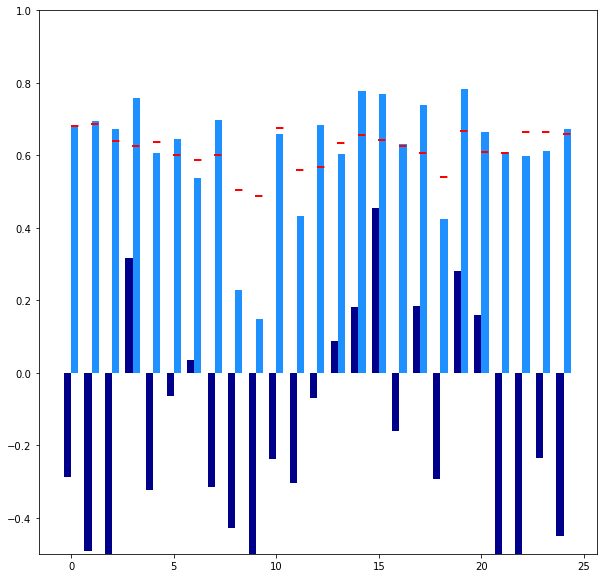

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

xs = np.arange(25)
width = 0.35 
rects1 = ax.bar(xs - width/2, all_r2_latFeature, width, label='x', color="darkblue")
rects2 = ax.bar(xs + width/2, all_r2_cpgRetrieved, width, label='x2',color="dodgerblue")
for x in xs:
    ax.hlines(xmin=x+width/2-0.2, xmax=x+width/2+0.2, y=all_r2_random[x], linestyles='--', linewidth=2, color='r')

ax.set_ylim(-0.5, 1)

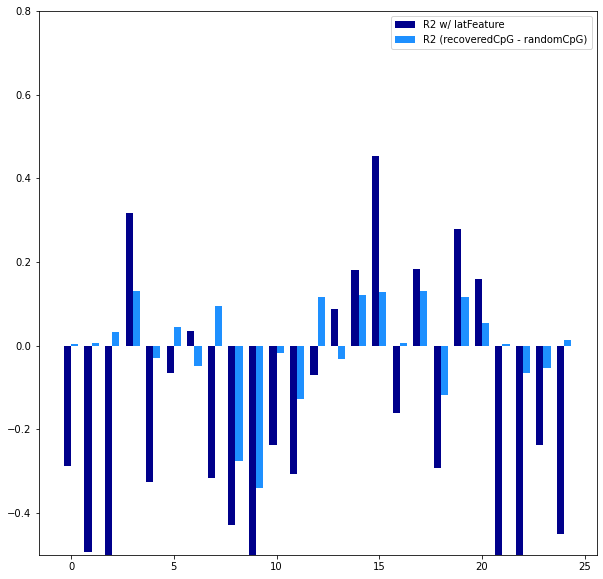

In [16]:
delta_gain = np.array(all_r2_cpgRetrieved) - all_r2_random

fig, ax = plt.subplots(figsize=(10,10))

x = np.arange(25)
width = 0.35 

rects1 = ax.bar(x - width/2, all_r2_latFeature, width, color="darkblue", label="R2 w/ latFeature")
rects2 = ax.bar(x + width/2, delta_gain, width, color="dodgerblue", label="R2 (recoveredCpG - randomCpG)")
ax.set_ylim(-0.5, 0.8)
ax.legend()

## Investigate CpGs from important latSpace Features

1. check overlap between l1_regularisaton and no regularisation (explains difference in `delta_gain`?)
2. overlap with EWAS CpGs?

[3, 6, 13, 14, 15, 17, 19, 20]

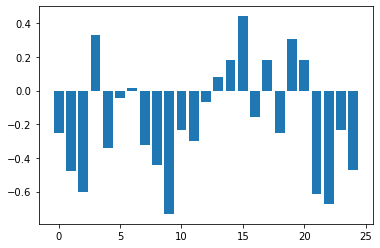

In [7]:
fig, ax = plt.subplots()
ax.bar(range(25), all_r2_latFeature)

[i for i,x in enumerate(all_r2_latFeature) if x > 0]


In [10]:
### Read in EWAS results from EWAS cataloge (all results!)
ewas = pd.read_table("data/results.txt", low_memory=False)
studies = pd.read_table("data/studies.txt")

### Only include studies carreid out in Whole blood and measuring Age 
studies_filtered = studies[(studies["Tissue"] == "Whole blood") & (studies["Trait"].str.contains("age", case=False))]
ewas_studies = ewas[ewas["StudyID"].isin(studies_filtered["StudyID"])]

In [13]:
for latFeature_i in [15, 5, 9]: # 15 is important, 5 & 9 not so much

    PATH_pert= f"/home/sonja/PROJECTS/VAE_methylation/perturbations/results/l1_regularisation/latSize_25/latFeature_{latFeature_i}"
    print(f"\nLatFeature: {latFeature_i}")

    cpgs = pd.read_csv(f"{PATH_pert}/cpgs_high.txt", header=None)[0].tolist() #cpgs_high_medium_low.txt

    ewas_filtered = ewas_studies[ewas_studies["CpG"].isin(cpgs)]
    #print(ewas_filtered.shape)

    # ### How many CpGs are not significant?
    num_notsig = len([i for i in cpgs if i not in ewas_filtered["CpG"].unique()])
    print(f"Number of not significant CpGs in cluster: {num_notsig} \t Ratio significant: {round(1-(num_notsig/len(cpgs)),2)}")

    # ### Which CpGs are not significant?
    print([i for i in cpgs if i not in ewas_filtered["CpG"].unique()])


LatFeature: 15
Number of not significant CpGs in cluster: 4 	 Ratio significant: 0.95
['cg11141652', 'cg04234412', 'cg27376941', 'cg17005068']

LatFeature: 5
Number of not significant CpGs in cluster: 4 	 Ratio significant: 0.95
['cg11141652', 'cg04234412', 'cg17005068', 'cg00740510']

LatFeature: 9
Number of not significant CpGs in cluster: 9 	 Ratio significant: 0.67
['cg12419862', 'cg21256200', 'cg11141652', 'cg24694833', 'cg04234412', 'cg17005068', 'cg11466708', 'cg25703541', 'cg09033563']


In [20]:
# tmpCpGs = test_dataset["beta"].columns.tolist()

# num_notsig = len([i for i in tmpCpGs if i not in ewas_studies["CpG"].unique()])
# print(f"Number of not significant CpGs in cluster: {num_notsig} \t Ratio significant: {round(1-(num_notsig/len(tmpCpGs)),2)}")

Number of not significant CpGs in cluster: 813 	 Ratio significant: 0.83


In [23]:
len(tmpCpGs)-813

3858